In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
from pyomo import environ
from pyomo.core import *
import pyomo.environ as pyo
np.random.seed(0)
from utils import *
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

/Users/antonioalcantaramata/opt/anaconda3/envs/py39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data

In [2]:
data = pd.read_csv('data_house_japan/data_clean.csv', index_col=0)
data.index = pd.to_datetime(data.index)

y = data['demand']
X = data.drop(['demand'], axis=1, inplace=False)

In [3]:
val_ind = X.index[(X.index >= pd.to_datetime('2018-11-01')) & (X.index < pd.to_datetime('2018-12-01'))]
test_ind = X.index[X.index >= pd.to_datetime('2018-12-01')]

## Optimization Model

In [4]:
def vpp_opt(pred_da, pred_solar, ramp_ch, ramp_ds, eta_ch, eta_ds, bat_maxcap, bat_initq, balance_price, n_sc, contextual_sample):
    
    model = pyo.ConcreteModel()
    
    model.N = pyo.RangeSet(0,23)
    model.W = pyo.RangeSet(1,n_sc) # scenarios
    model.var_ind = pyo.Set(initialize=contextual_sample.columns.sort_values())
    
    pi = [1/n_sc for i in range(n_sc)]
    exp_da = pred_da.mean(axis=1)
    
    
    # Variables
    model.x = pyo.Var(model.var_ind, model.N, within=pyo.Reals) # first stage decisions about price and contextual variables
    model.q_da = pyo.Var(model.N, within=pyo.Reals) # quantity of energy to buy/sell in the day-ahead market
    model.q_bal = pyo.Var(model.N, model.W, within=pyo.NonNegativeReals) # quantity of energy to buy in the balance market
    
    model.B = pyo.Var(model.N, model.W, within=pyo.NonNegativeReals) # battery status at time t and scenario omega
    model.delta_ds = pyo.Var(model.N, model.W, within=pyo.NonNegativeReals) # quantity to charge and discharge into the batteries
    model.delta_ch = pyo.Var(model.N, model.W, within=pyo.NonNegativeReals)
    
    model.y = pyo.Var(pyo.Any, dense=False, domain=pyo.Reals) # learned variables (demand)
    
    model.profit = pyo.Var(model.W, within=pyo.Reals) # saving profit per scenario
    
    
    
    #definition of the objective function
    def obj_expression(model):
        return sum(pi[w-1] * model.profit[w] for w in model.W)
    model.OBJ = pyo.Objective(rule=obj_expression, sense=pyo.maximize)
    
    
    #saving profit  
    def const1_rule(model, w):
        return model.profit[w] ==  sum(model.y['demand', n, w]*model.x['price',n] - pred_da[n,w-1]*model.q_da[n] - balance_price*model.q_bal[n,w] for n in model.N)
    model.const1 = pyo.Constraint(model.W, rule=const1_rule)
    
    
    #constraint demand balance
    def const2_rule(model,n,w): 
        return model.y['demand', n, w] <=  model.q_da[n] + model.q_bal[n,w] + pred_solar[n,w-1] + eta_ds*model.delta_ds[n,w] - model.delta_ch[n,w]
    model.const2 = pyo.Constraint(model.N, model.W, rule=const2_rule)
    
    
    #constraint for charging ramp
    def const3_rule(model,n,w):
        return model.delta_ch[n,w] <= ramp_ch
    model.const3 = pyo.Constraint(model.N, model.W, rule=const3_rule)
    
    
    #constraint for discharging ramp
    def const4_rule(model,n,w):
        return model.delta_ds[n,w] <= ramp_ds
    model.const4 = pyo.Constraint(model.N, model.W, rule=const4_rule)
    
    
    #constraint for battery status
    def const5_rule(model,n,w):
        if n==23:
            return pyo.Constraint.Skip
        else:
            return model.B[n+1,w] == model.B[n,w] - model.delta_ds[n,w] + eta_ch * model.delta_ch[n,w]
    model.const5 = pyo.Constraint(model.N, model.W, rule=const5_rule)
    
    
    #constraint for battery max capacity
    def const6_rule(model,n,w):
        return model.B[n,w] <= bat_maxcap
    model.const6 = pyo.Constraint(model.N, model.W, rule=const6_rule)
    
    
    #constraint for battery init 
    def const7_rule(model,w):
        return model.B[0,w] == bat_initq
    model.const7 = pyo.Constraint(model.W, rule=const7_rule)
    
    def const8_rule(model):
        return sum(model.B[23,w] for w in model.W )/n_sc >= bat_initq
    model.const8 = pyo.Constraint(rule=const8_rule)
    
    
    #constraint for fixing contextual information
    def const9_rule(model,x_ind,n):
        if x_ind=='price':
            return pyo.Constraint.Skip
        else:
            return model.x[x_ind,n] == contextual_sample.loc[n,x_ind]
    model.const9 = pyo.Constraint(model.var_ind, model.N, rule=const9_rule)
    
    
    #limits to price offered to consumers
    def const10_rule(model,n):
        return model.x['price',n] >= exp_da[n]*0.75
    model.const10 = pyo.Constraint(model.N, rule=const10_rule)
    
    def const11_rule(model,n):
        return model.x['price',n] <= exp_da[n]*1.25
    model.const11 = pyo.Constraint(model.N, rule=const11_rule)
    
    def const12_rule(model):
        return sum(model.x['price',n] for n in model.N) <= sum(exp_da[n] for n in model.N)
    model.const12 = pyo.Constraint(rule=const12_rule)
    
    
    return model

## Distributional Constraint Learning

#### Model fitting and constriant generation

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from distcl import distcl
cl_tool = distcl(X, y, n_preds=24, val_ind=val_ind, test_ind=test_ind)

In [9]:
model, preds_test, sd_test, y_test = cl_tool.train(n_hidden=1, n_nodes=50, iters=5000, drop=0.05, learning_rate=1e-4)

DistFCNN(
  (lin_layers): ModuleList(
    (0): Linear(in_features=32, out_features=50, bias=True)
  )
  (output_mean_layer): Linear(in_features=50, out_features=1, bias=True)
  (output_sd_layer): Linear(in_features=50, out_features=1, bias=True)
  (droput_layers): ModuleList(
    (0): Dropout(p=0.05, inplace=False)
  )
)
cpu
epoch 0 loss 5.8941826820373535
epoch 500 loss -0.6852393746376038
epoch 1000 loss -1.5578702688217163
epoch 1500 loss -1.6526299715042114
epoch 2000 loss -1.717334508895874
epoch 2500 loss -1.7054193019866943
epoch 3000 loss -1.7007873058319092
epoch 3500 loss -1.6992191076278687
epoch 4000 loss -1.6937556266784668
epoch 4500 loss -1.6799975633621216
NN fitting process finished with a validation GAUSSIANNLL loss of -1.7300406694412231 in epoch 2359


In [10]:
cons = cl_tool.constraint_build(model)
cons.to_csv('constraints_1_50.csv')

In [11]:
cons = pd.read_csv('constraints_1_50.csv', index_col=0)
cons

,intercept,layer,node,node_0,node_1,node_2,node_3,node_4,node_5,node_6,...,node_40,node_41,node_42,node_43,node_44,node_45,node_46,node_47,node_48,node_49
0,-0.341274,0,0,0.059144,0.139839,-0.043810,-0.017901,-0.106881,-0.015353,0.086557,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.032375,0,1,0.065363,-0.138616,-0.199087,-0.188902,-0.049152,0.114783,0.067813,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.072603,0,2,0.001839,-0.205053,-0.079396,0.100733,0.041498,0.065541,-0.289053,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.105449,0,3,-0.003873,-0.008751,-0.052204,-0.074880,0.153130,-0.045285,-0.047028,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.037887,0,4,-0.066847,-0.027164,0.146742,0.026056,0.012545,0.054920,0.040278,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,-0.047267,0,5,-0.003968,-0.107701,-0.159229,-0.190326,-0.064788,-0.046111,-0.184552,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,-0.048427,0,6,-0.039214,0.166037,-0.067398,-0.239165,-0.018337,0.045016,-0.163640,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,-0.079454,0,7,-0.182980,0.043376,-0.238728,0.064462,-0.127683,-0.064128,0.050406,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,-0.122890,0,8,-0.086716,0.079964,0.037965,-0.018133,-0.049124,-0.013272,0.124316,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,-0.056735,0,9,0.024660,-0.018393,-0.008355,-0.025187,-0.082612,-0.060871,0.051483,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Price/Solar power predictions

In [12]:
da_df = pd.read_csv('data_house_japan/preds_dayahead_december2.csv', index_col=0)
da_df.index = pd.to_datetime(da_df.index)

solar_df = pd.read_csv('data_house_japan/preds_solar_december2.csv', index_col=0)
solar_df.index = pd.to_datetime(solar_df.index)

## Embedding and Optimization

In [13]:
test_days = pd.date_range('2018-12-12', '2018-12-12')

opt_profit = {}
profit_df = pd.DataFrame()


for t, day in enumerate(test_days):
    print(day)
    pred_da_tmp = da_df[da_df.index.date == day].to_numpy()
    pred_solar_tmp = solar_df[solar_df.index.date == day].to_numpy()
    X_tmp = X[X.index.date == day]#.to_numpy()
    X_tmp.reset_index(drop=True, inplace=True)
    
    conceptual_model= vpp_opt(pred_da=pred_da_tmp, pred_solar=pred_solar_tmp, ramp_ch=5000, ramp_ds=5000, bat_maxcap=15000, eta_ch=0.9, eta_ds=0.9, 
                                bat_initq=8000, balance_price=100, n_sc=300, contextual_sample=X_tmp)
    
    cl_tool.const_embed(opt_model=conceptual_model, constaints=cons, outcome='demand', n_scenarios=300)
    
    opt = pyo.SolverFactory('gurobi')
    opt.options['threads'] = 8
    opt.options['NonConvex'] = 2
    results = opt.solve(conceptual_model, tee=True) 
    
    opt_profit[t] = value(conceptual_model.OBJ)
    profit_df = profit_df.append([value(conceptual_model.profit[:])])

2018-12-12 00:00:00
Set parameter Username
Academic license - for non-commercial use only - expires 2022-12-04
Read LP format model from file /var/folders/d_/m6htzr0j1j36bf_5j40ltp0r0000gn/T/tmppi1fbmni.pyomo.lp
Reading time = 0.22 seconds
x39541: 47643 rows, 39541 columns, 193465 nonzeros
Set parameter Threads to value 8
Set parameter NonConvex to value 2
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 47643 rows, 39541 columns and 193465 nonzeros
Model fingerprint: 0x7175f188
Model has 300 quadratic constraints
Variable types: 38341 continuous, 1200 integer (1200 binary)
Coefficient statistics:
  Matrix range     [3e-07, 1e+03]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+02]
  Objective range  [3e-03, 3e-03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-16, 2e+04]
Presolve removed 26429 rows and 4237 columns
Presolve time: 0.21s
Presolved: 

In [18]:
opt_price = {}
opt_mean = {}
opt_sd = {}
for n in range(24):
    opt_price[n] = value(conceptual_model.x['price',n])
    opt_mean[n] = value(conceptual_model.y['demand', n,'mean'])
    opt_sd[n] = value(conceptual_model.y['demand', n,'sd'])

In [19]:
sum(opt_profit.values())

147937.32152586823

In [20]:
profit_df.reset_index(inplace=True, drop=True)
np.sqrt(profit_df.var(axis=1).sum())

70418.62482245507

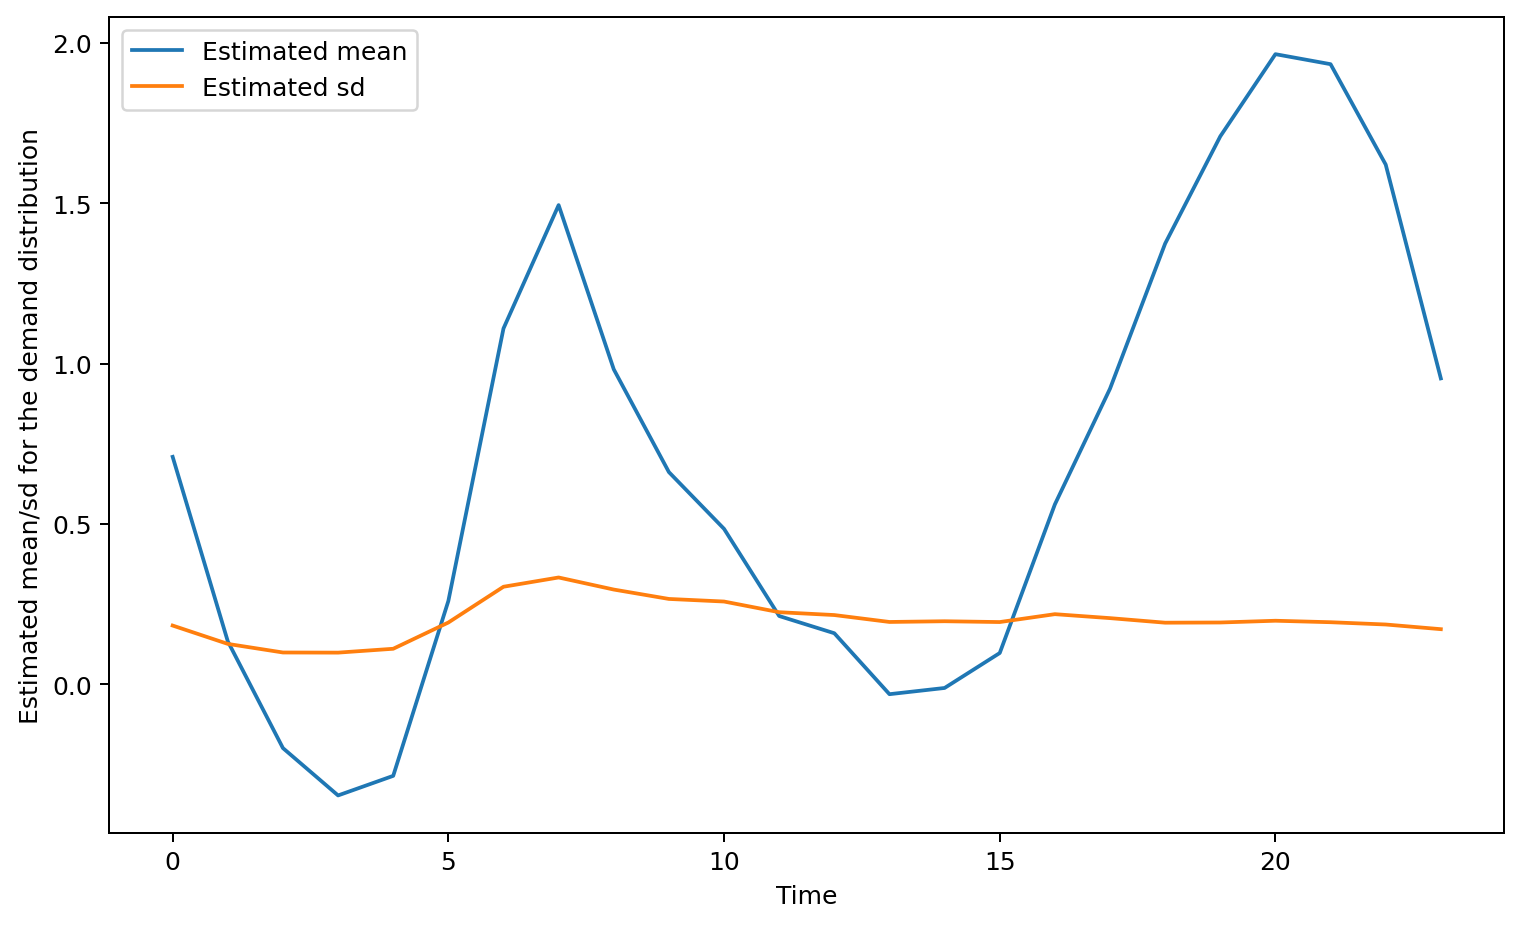

In [24]:
plt.figure(figsize=(10, 6), dpi=180)
plt.plot(opt_mean.values(), label='Estimated mean')
plt.plot(opt_sd.values(), label='Estimated sd')
plt.ylabel('Estimated mean/sd for the demand distribution')
plt.xlabel('Time')
plt.legend()
plt.show()

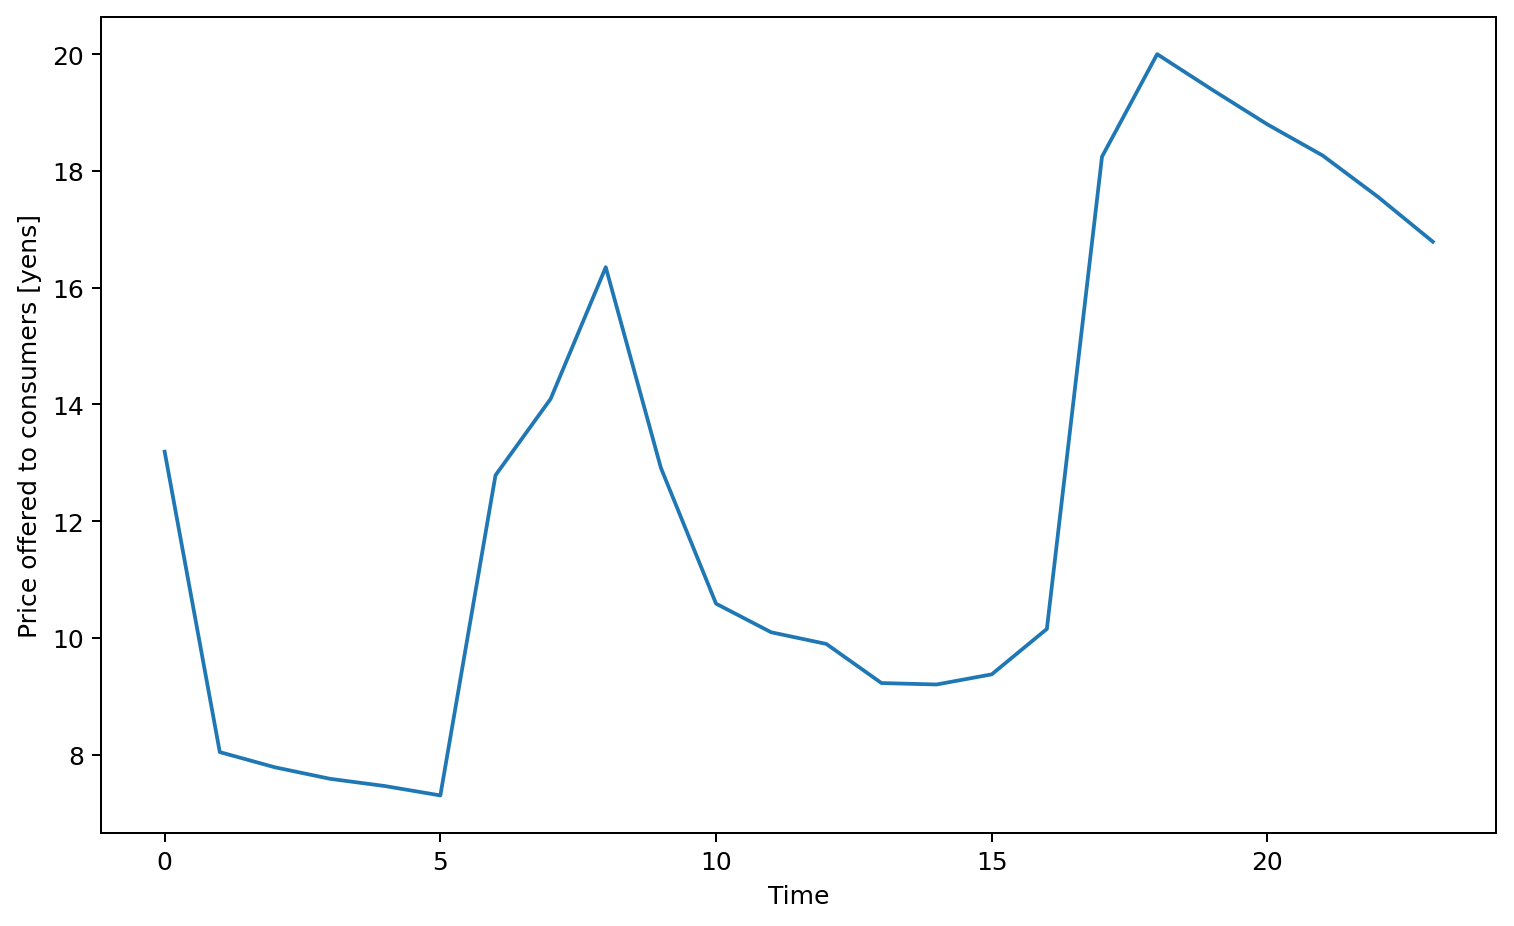

In [25]:
plt.figure(figsize=(10, 6), dpi=180)
plt.plot(opt_price.values())
plt.ylabel('Price offered to consumers [yens]')
plt.xlabel('Time')
plt.show()